# SENDY LOGISTICS DATA PREPROCESING 
---
1. Make your **1st line a comment**, just to give clarity to the Team about the task/code used.
2. If you happen to get a **CODE snippet** from **stackoverflow/Blog**, Make your **2nd line the link referencing the code/post**. for later reference if team members need clarity.

---
## HEADS UP
*The following steps will serve as a guide-line not mandatory step and they might not be in order.*

- split data into subsets (train & validation/test)
- data preparation
    - imputing misssing values
    - Changing Data Types (if necessary e.g [df.convert_dtypes()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.convert_dtypes.html)| [df.astype()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html) based features [pd.to_datetime(df['date'])](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html?highlight=to_datetime))
    - One Hot Encoding [more](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
    - Ordinal Encoding [more](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder)
    - Target Encording (Do more Research)
    - Target Transformation Regressor (Do [more Research](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html?highlight=transform#sklearn.compose.TransformedTargetRegressor) )
        - Target might be transformed when linear algorithms such as Linear Regression, etc.
- [Scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=scale#sklearn.preprocessing.StandardScaler) & transform 
- feature Engineering (read more)
    - Feature Interaction
    - Bin Numeric Features
    - Trigonometry Features
    - Group Features
    - Polynomial Features
    - Combine Rare Levels
- feature Selection (AKA variables selection)
    - SelectKBest, SelectFromModel, RFE [more here](https://scikit-learn.org/stable/search.html?q=feature+selection) 
    - Feature Importance
    - collinearity (Remove Multicollinearity using threshold >= 0.9, )
        - rules: if feature A is highly correlated with feature B but A is less corelated with Target, then Remove Feature A
    - Principal Component Analysis (PCA)
    - VarianceThreshold [view](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html?highlight=feature%20selection#sklearn.feature_selection.VarianceThreshold)
        - SET Threshold and Ignore Low Variance fearues below the Threshold.
- Clustering (Removing Outliers / creating clusters)
---

# 1. Library Imports
---
Keep it clean, import Libraries at the Top!

In [0]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from datetime import datetime


# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# More imports Below
from sklearn.ensemble import RandomForestRegressor


# 2. Import Datasets
---
- By Default the notebook is using the github links to fetch data remotely, change to local if need be. 
> e.g replace URL_TRAIN with URL_local_TRAIN
- DO NOT FORGET TO CHANGE BACK THE LINKS BEFORE CREATING A PULL REQUEST
> Use The following Links for Local Machine NoteBooks/Jupyterlab (this will save data)
>This assumes the notebook.ipynb is inside the Notebooks folder

```python

    URL_local_TRAIN = "/data/Train.csv"
    URL_local_TEST = "/data/Test.csv"
    URL_local_RIDERS = "/data/Riders.csv" 
    URL_local_DD = "/data/VariableDefinitions.csv"

```

In [0]:
# CONSTANTS

URL_TRAIN = "https://raw.githubusercontent.com/Explore-EDSA-2020/Sendy-Logistics-Challenge/master/data/Train.csv"
URL_TEST = "https://raw.githubusercontent.com/Explore-EDSA-2020/Sendy-Logistics-Challenge/master/data/Test.csv"
URL_RIDERS = "https://raw.githubusercontent.com/Explore-EDSA-2020/Sendy-Logistics-Challenge/master/data/Riders.csv" 
URL_DD = "https://raw.githubusercontent.com/Explore-EDSA-2020/Sendy-Logistics-Challenge/master/data/VariableDefinitions.csv" # Data Dictionary


In [0]:
# reading the data to dataframe

train_df  = pd.read_csv(URL_TRAIN)
test_df   = pd.read_csv(URL_TEST)
riders_df = pd.read_csv(URL_RIDERS)
data_dictionary_df = pd.read_csv(URL_DD)


In [75]:
# making a copy of the data to avoid altering the original data
train_riders = train_df.copy()
test_riders  = test_df.copy()

# merged train with riders
train_riders = train_riders.merge(riders_df, how='left', on='Rider Id')
test_riders  = test_riders.merge(riders_df, how='left', on='Rider Id')

# view dimension
print('train without riders: ', train_df.shape)
print('train merged with riders: ', train_riders.shape)
print('---------------------------------------')
print('test without riders: ', test_df.shape)
print('test merged with riders: ', test_riders.shape)

train without riders:  (21201, 29)
train merged with riders:  (21201, 33)
---------------------------------------
test without riders:  (7068, 25)
test merged with riders:  (7068, 29)


# **Custom** **Functions**

In [0]:
# Lets get the features that are highly correlated with price
def get_correlated_feature(corrdata, target: str , threshold:float):
    """Returns  features with a custom correlation threshold with the target """
    
    corrdata = df.corr('pearson')
    return pd.DataFrame({name: [corrdata[name][target]]  for name in corrdata.index 
                     if abs(corrdata[name][target]) > threshold },
                     index=['Corr value']).T
        

In [0]:
def datetime_to_seconds(df):
    """Returns a dataframe with time converted to seconds"""
    for col in df.columns:
      if col.endswith('Time'):
           df[col] = pd.to_datetime(df[col])
           df[col.split(' -')[0]+'_hour'] = df[col].dt.hour
           df[col.split(' -')[0]+'_minute'] = df[col].dt.minute
           df[col.split(' -')[0]+'_second'] = df[col].dt.second
           df[col]= (df[col] - pd.to_datetime(pd.to_datetime('today').date())).astype('timedelta64[s]')
    return df

In [0]:
def get_Duplicate_Columns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
                
    return list(duplicateColumnNames)

In [0]:
def get_cadinality(df , threshold=0):
    
    return pd.DataFrame(data= {column: (df[column].nunique()) for column in df.columns if df[column].nunique() < threshold}, 
             index=['Cardinality per Feature']
             ).T

In [0]:
def to_weekday_name(df, ends_with):

    weekday_names = {1:"Monday", 2:"Tuesday", 3: "Wednesday", 4:"Thursday", 5:"Friday", 6: "Saturday", 7:"Sunday"}
    for col in df.columns:
        if col.endswith(ends_with):
           df[col] = df[col].map(weekday_names) 
    
    return df

In [0]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.tight_layout()
    plt.show()

In [0]:
def to_platform_type(df):
    """Returns a dataframe with encoded platform feature"""

    types = {1:'Type 1',2:'Type 2',3:'Type 3',4:'Type 4'}

    df['Platform Type'] = df['Platform Type'].map(types)
    
    return df

# 3. Data Preprocessing
---
Avoid imputing missing values from test data, instead use a pipeline so we can inherit the **train properties** e.g mean, median, mode(most common) or constant: "missing". **Ask why in the upcoming meeting!**

---
You take it from here!

---

**Let's do a quick Recap from our EDA notebook report.**

1. Missing values
  - Temperature had +-20% of NANs (We can impute the NANs with mean or median based on the Distribution)
  - Precipitation had +-97% of NAN (We drop this since imputation will somehow reduce the variance of the feature)

2. create Time based Features
> Timedelta <br>
> is_not_weeked / is_weeked <br>
> Rush hours <br>
> time of the day {morning, afternoon, evening} <br>
> seasonality or quarter of month or year<br>
<br>
>  Pickup-Time
  - hour 
  - minutes

> Confirmation-Time
  - hour 
  - minutes
  - Seconds

> Destination - Time
  - hour 
  - minutes
  - Seconds

**Create geo based features**
- Distance

**Riders features**
> riders exprience based on age {years, months, days} <br>
> factor rating

**Last but important**
> check linear regression assumptions

In [0]:
# We need to remove the outliers
train_riders = train_riders[train_riders['Placement - Weekday (Mo = 1)'] == train_riders['Confirmation - Weekday (Mo = 1)']]
train_riders = train_riders[train_riders['Placement - Day of Month'] == train_riders['Confirmation - Day of Month']]

# To drop columns
features_to_drop = ['User Id',
                'Rider Id',
                'Order No', # not for test
                'Vehicle Type',
                'Precipitation in millimeters',
                'Confirmation - Day of Month',
                'Confirmation - Weekday (Mo = 1)',
                'Arrival at Pickup - Day of Month',
                'Arrival at Pickup - Weekday (Mo = 1)',
                'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)',
                'Pickup - Weekday (Mo = 1)'
                'Arrival at Destination - Day of Month',
                ]

def drop_columns(df, features_to_drop, df_type:'test or train'):

    if df_type.upper() == 'TEST':
        features_to_drop.remove('No_Of_Orders')  # not for test
    
    return df.drop([column for column in df.columns if column in features_to_drop], axis=1)



# **feature engineering**

In [0]:
# train_riders['Placement Time'] = [datetime.strptime(i,'%I:%M:%S %p').time() for i in train_riders['Placement - Time']]
train_riders['Placement - Time'] = pd.to_datetime(train_riders['Placement - Time'])
train_riders.sample()

In [0]:
# Time Based Features
#--------------------
# 'Placement - Time'
# 'Confirmation - Time' 
# 'Arrival at Pickup - Time'
# 'Pickup - Time'
# 'Arrival at Destination - Time'
# ------------------


time_features = ['Placement - Time',
                 'Confirmation - Time' ,
                 'Arrival at Pickup - Time',
                 'Pickup - Time',
                 'Arrival at Destination - Time',
                 ]


def to_seconds(df, time_features):
    """Returns a Dataframe with time features converted to seconds"""

    for column in time_features:

        if column in df:
           df[column] = pd.to_datetime(df[column])

           df[column.split(' -')[0]+'_hour'] = df[column].dt.hour
           df[column.split(' -')[0]+'_minute'] = df[column].dt.minute
           df[column.split(' -')[0]+'_second'] = df[column].dt.second
           df[column]= (df[column] - pd.to_datetime(pd.to_datetime('today').date())).astype('timedelta64[s]')
    
    return df



In [0]:
# Delta Features
# ----------------------

# -----------------------
# Train and Test
# ----------------
# 'delta-Time-Confirmation_Placement'           ---> 'Confirmation - Time', 'Placement - Time'
# 'delta-Time-Arrival-at-Pickup_Confirmation'   ---> 'Arrival at Pickup - Time', 'Confirmation - Time'
# 'delta-Time-Pickup_Arrival-at-Pickup'         ---> 'Pickup - Time', 'Arrival at Pickup - Time'
# ----------------
# Train Not in TEST
# ----------------
# 'delta-Time-Arrival-at-Destination_Pickup'    ---> 'Arrival at Destination - Time', 'Pickup - Time'
# 'delta-Time-Arrival-at-Destination_Placement' ---> 'Arrival at Destination - Time', 'Placement - Time'

delta_cols = [
            ('delta-Time-Confirmation_Placement',  'Confirmation - Time', 'Placement - Time' ),
            ('delta-Time-Arrival-at-Pickup_Confirmation' ,'Arrival at Pickup - Time', 'Confirmation - Time'),
            ('delta-Time-Pickup_Arrival-at-Pickup', 'Pickup - Time', 'Arrival at Pickup - Time'),
            ('delta-Time-Arrival-at-Destination_Pickup', 'Arrival at Destination - Time', 'Pickup - Time'),
            ('delta-Time-Arrival-at-Destination_Placement','Arrival at Destination - Time', 'Placement - Time')
            ]

# Function to compute to delta
def to_delta(df, delta_cols):
      """Returns delta features from existing features"""

      for deltas in delta_cols:                               # Loop over the List of tuple [(output_name, col1, col2 ), (output_name, col1, col2 )]

          if deltas[1] in df and deltas[2] in df:             # check if columns exists
              df[deltas[0]] = df[deltas[1]] - df[deltas[2]]   # make delta feaure

      return df

In [0]:
# Distribution review
train_riders[numeric_cols+['Time from Pickup to Arrival']].hist(bins=50, figsize=(20,10))

# fix squeezed layout
plt.tight_layout()
plt.show()

**test new Features**
---
1. Run 
```pyhton
train_features = train_riders.copy()
train_features = drop_columns(train_features, features_to_drop, 'train')
```

2. Run
```python
    to_seconds(df, time_features)
```

3. Run
```python
    to_delta(df, delta_cols)
```

4. Check Distribution

```python
      # Distribution review

      train_features[[col for col in train_features.select_dtypes(include='number')]].hist(bins=50, figsize=(20,10))

      # fix squeezed layout
      plt.tight_layout()
      plt.show()

```

In [0]:
train_features = train_riders.copy()

In [0]:
train_features = drop_columns(train_features, features_to_drop, 'train')

In [0]:
train_features = to_seconds(train_features, time_features)

In [0]:
train_features = to_delta(train_features, delta_cols)

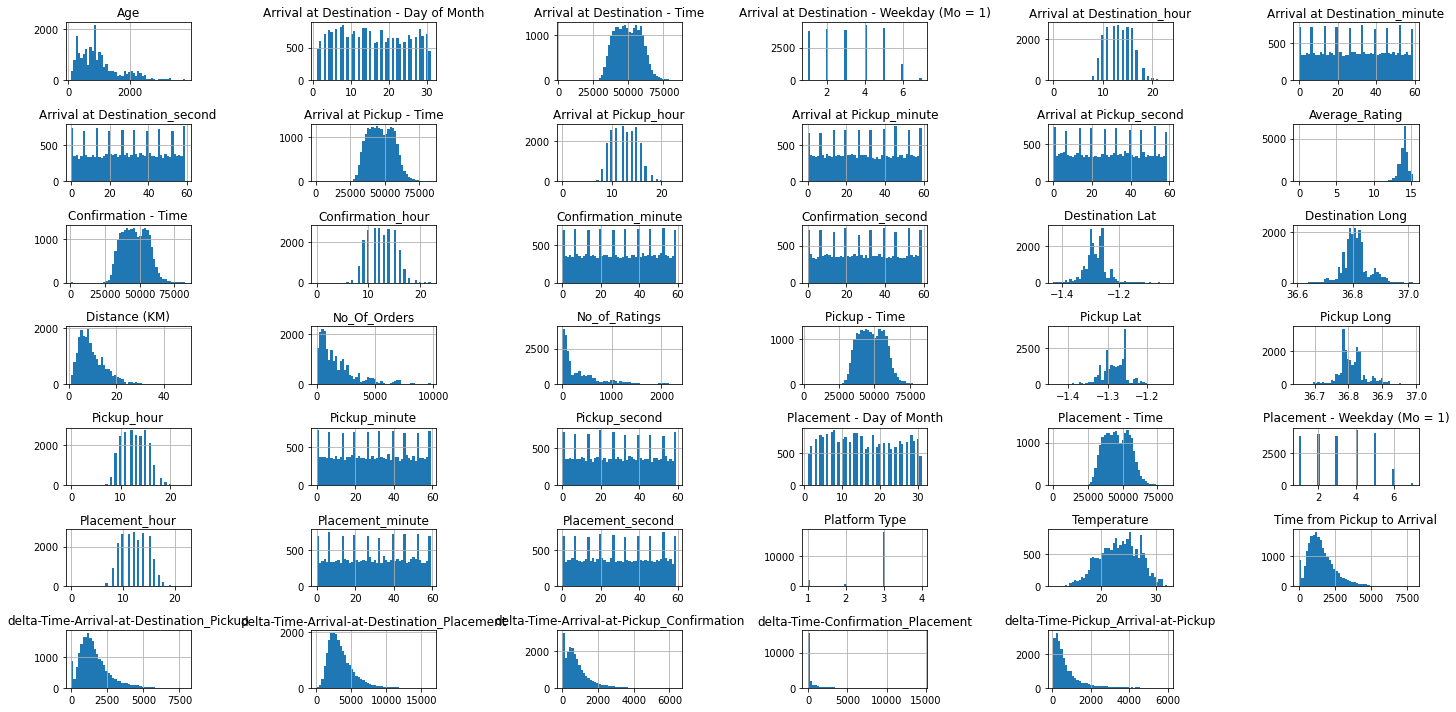

In [89]:
# Distribution review

train_features[[col for col in train_features.select_dtypes(include='number')]].hist(bins=50, figsize=(20,10))

# fix squeezed layout
plt.tight_layout()
plt.show()

In [81]:
train_features.select_dtypes(include='number').columns.to_list()

['Platform Type',
 'Placement - Day of Month',
 'Placement - Weekday (Mo = 1)',
 'Placement - Time',
 'Confirmation - Time',
 'Arrival at Pickup - Time',
 'Pickup - Time',
 'Arrival at Destination - Day of Month',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Time',
 'Distance (KM)',
 'Temperature',
 'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long',
 'Time from Pickup to Arrival',
 'No_Of_Orders',
 'Age',
 'Average_Rating',
 'No_of_Ratings',
 'Placement_hour',
 'Placement_minute',
 'Placement_second',
 'Confirmation_hour',
 'Confirmation_minute',
 'Confirmation_second',
 'Arrival at Pickup_hour',
 'Arrival at Pickup_minute',
 'Arrival at Pickup_second',
 'Pickup_hour',
 'Pickup_minute',
 'Pickup_second',
 'Arrival at Destination_hour',
 'Arrival at Destination_minute',
 'Arrival at Destination_second',
 'delta-Time-Confirmation_Placement',
 'delta-Time-Arrival-at-Pickup_Confirmation',
 'delta-Time-Pickup_Arrival-at-Pickup',
 'delta-Time-A

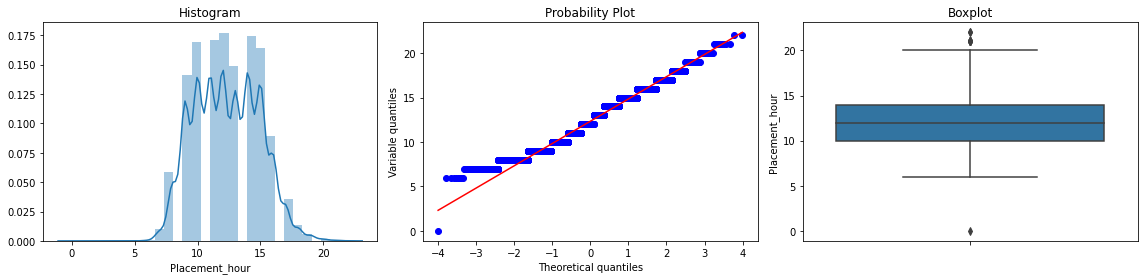

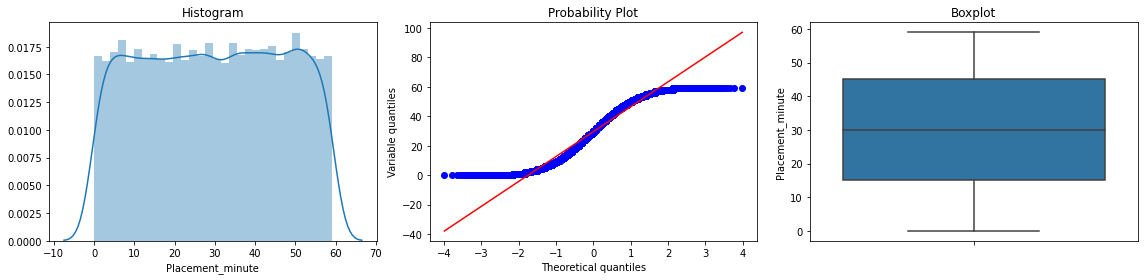

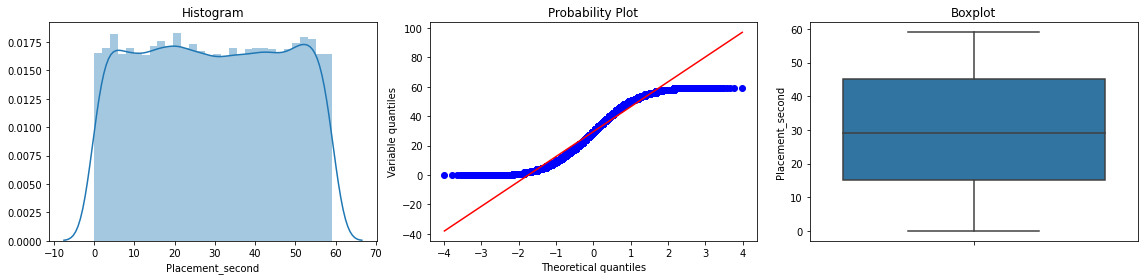

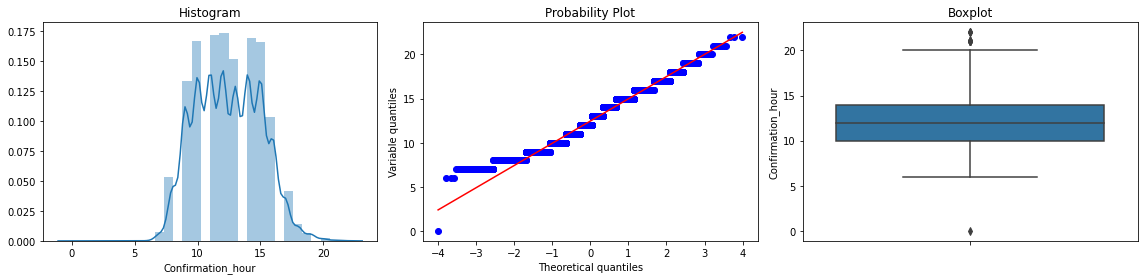

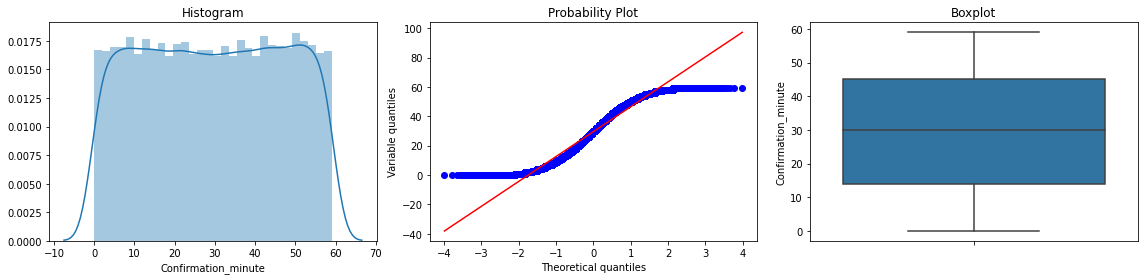

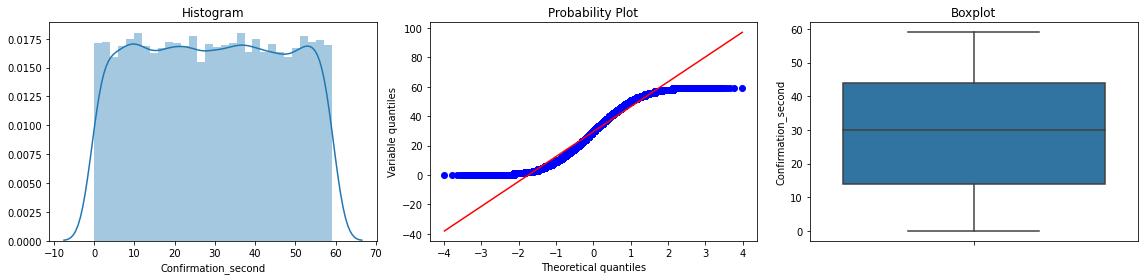

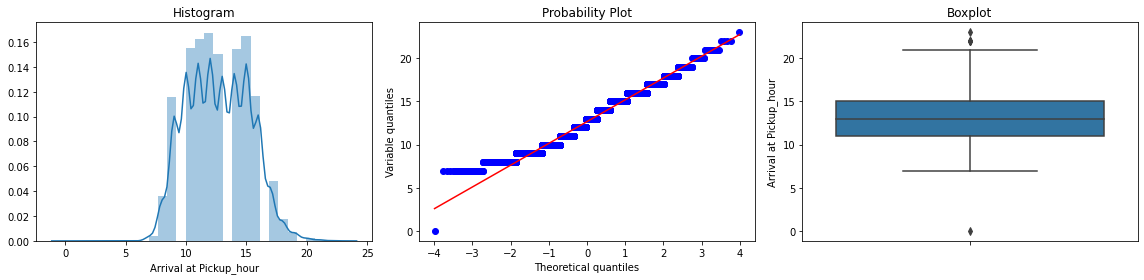

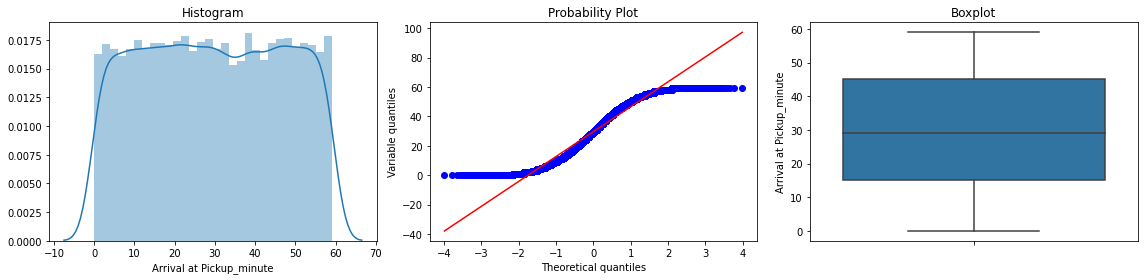

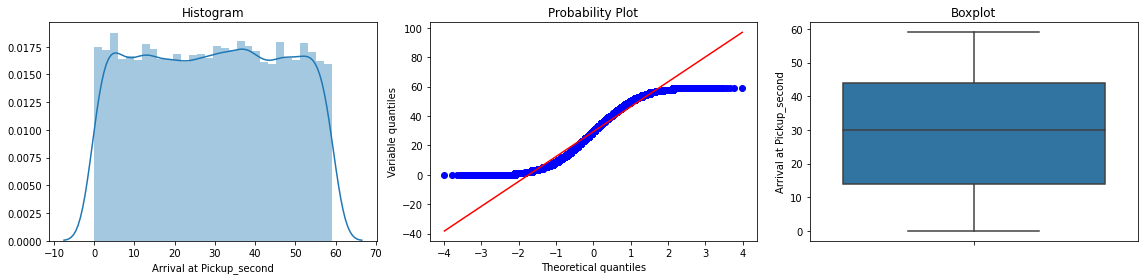

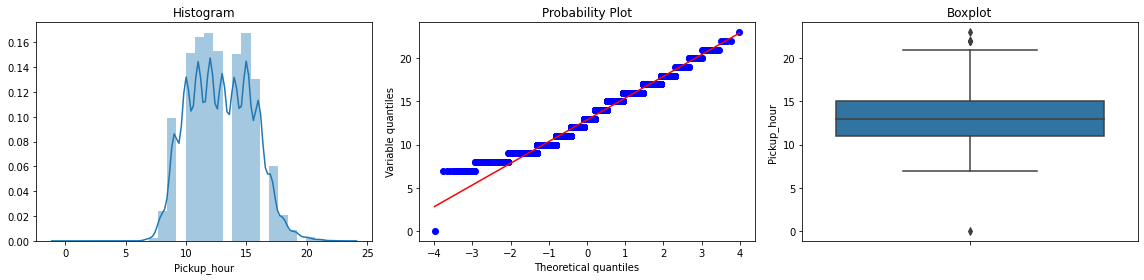

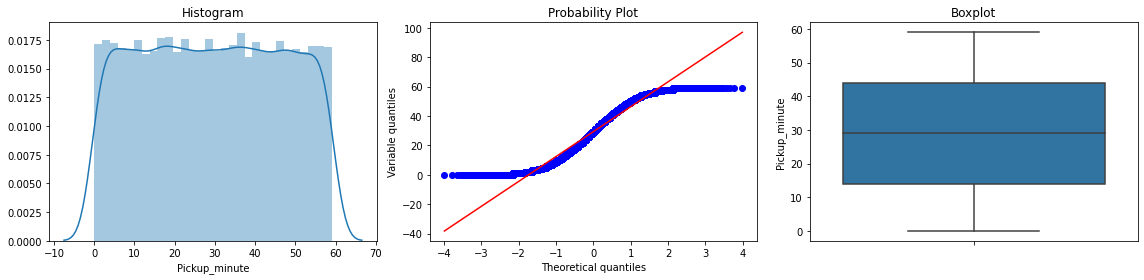

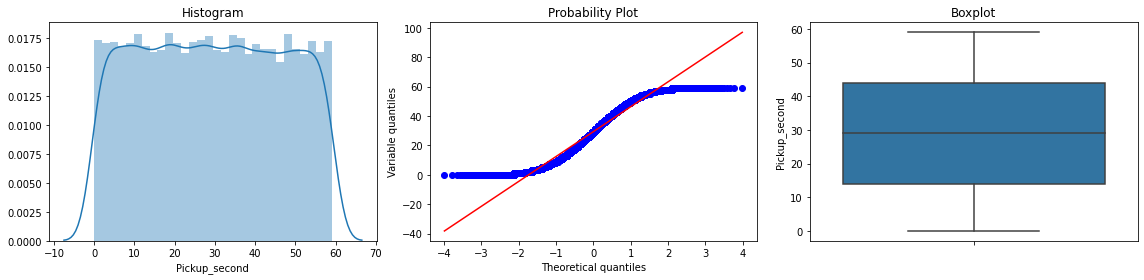

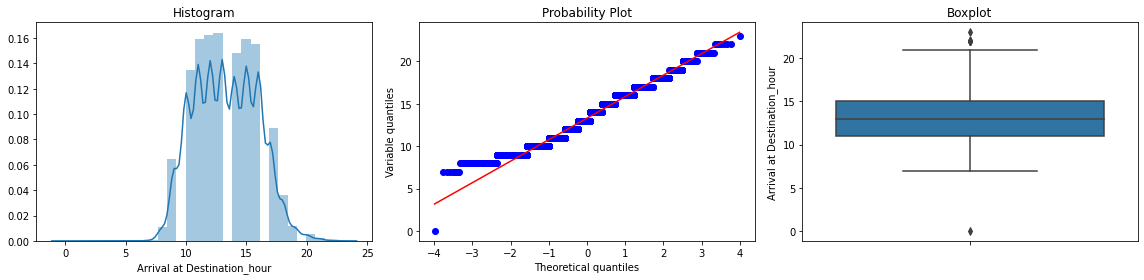

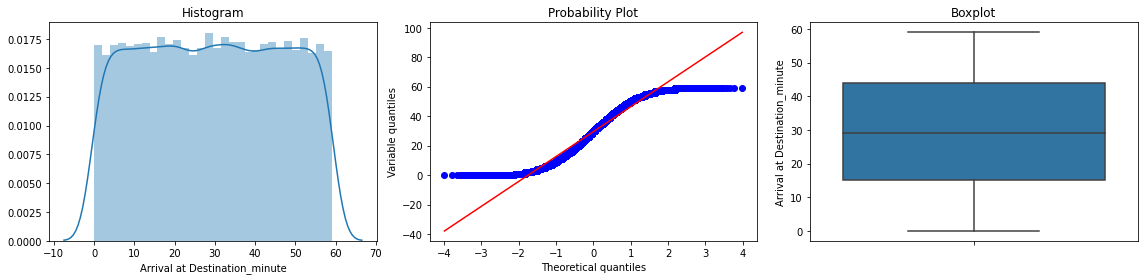

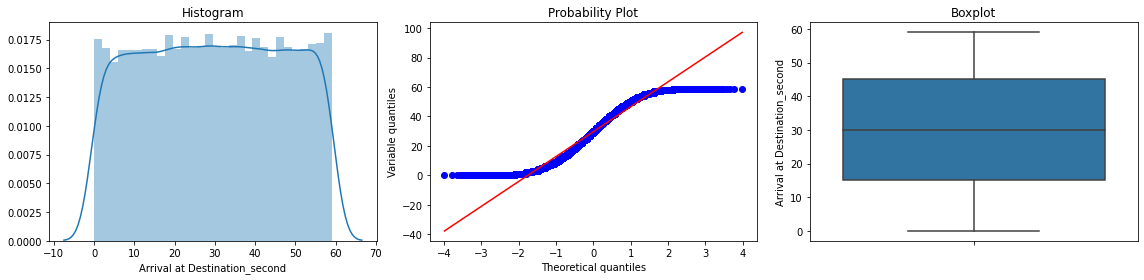

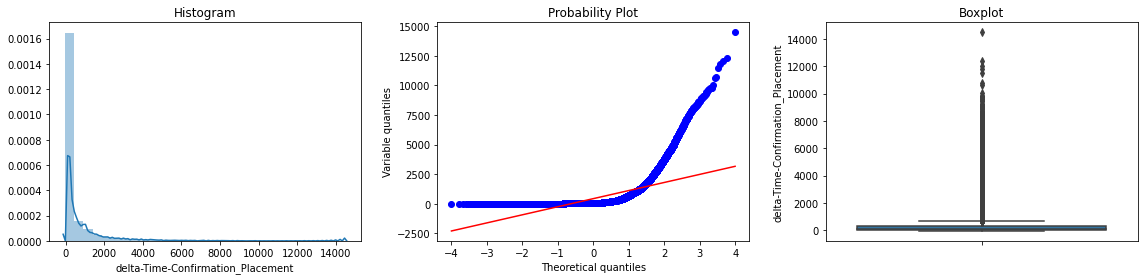

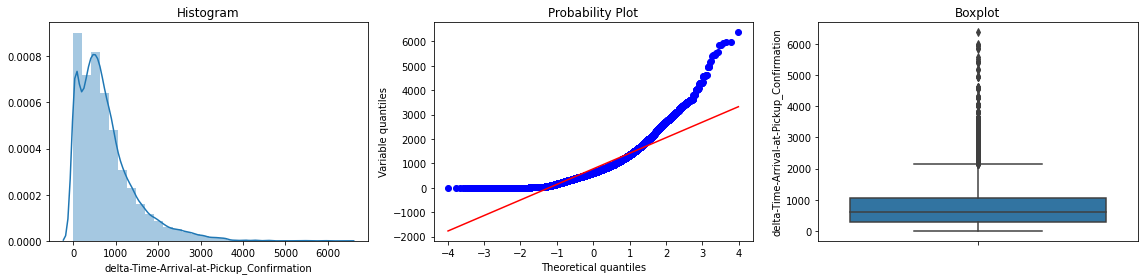

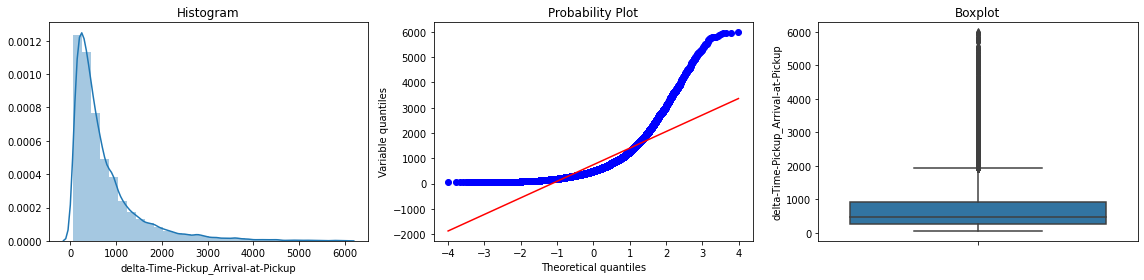

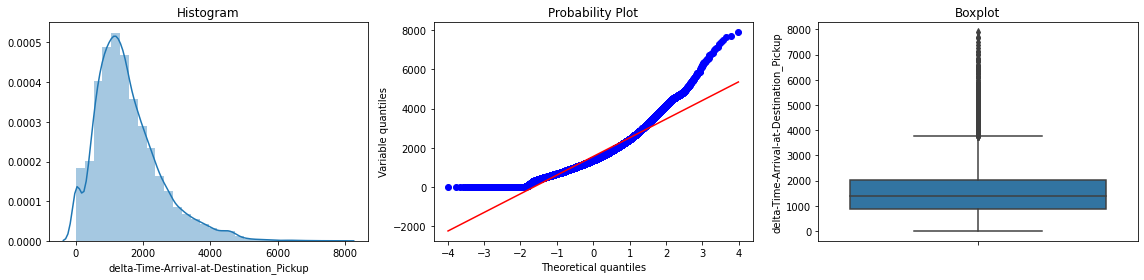

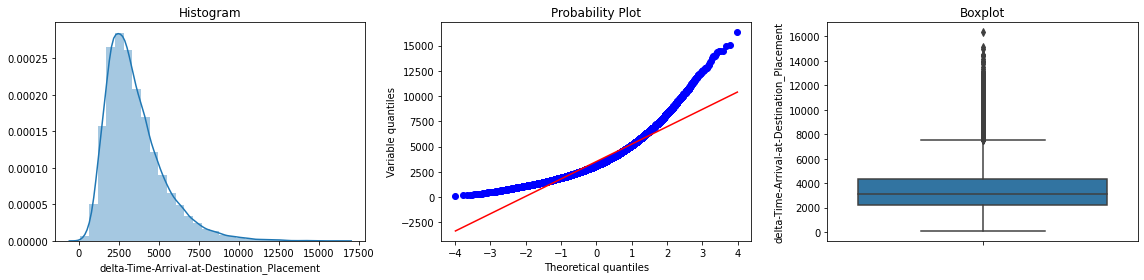

In [91]:
chec_cols =  ['Placement_hour',
 'Placement_minute',
 'Placement_second',
 'Confirmation_hour',
 'Confirmation_minute',
 'Confirmation_second',
 'Arrival at Pickup_hour',
 'Arrival at Pickup_minute',
 'Arrival at Pickup_second',
 'Pickup_hour',
 'Pickup_minute',
 'Pickup_second',
 'Arrival at Destination_hour',
 'Arrival at Destination_minute',
 'Arrival at Destination_second',
 'delta-Time-Confirmation_Placement',
 'delta-Time-Arrival-at-Pickup_Confirmation',
 'delta-Time-Pickup_Arrival-at-Pickup',
 'delta-Time-Arrival-at-Destination_Pickup',
 'delta-Time-Arrival-at-Destination_Placement']

for variable in chec_cols:
  diagnostic_plots(train_features, variable)

# **Data Preparation**

In [0]:
# separate numeric and categorical columns 
numeric_cols     = train_riders.select_dtypes(include='number').columns.to_list()
categorical_cols = train_riders.select_dtypes(exclude='number').columns.to_list()

# remove the target
numeric_cols.remove('Time from Pickup to Arrival')

## Train Test Split

In [18]:
# separate predictors from the target
X = train_riders.drop('Time from Pickup to Arrival', axis=1)
y = train_riders['Time from Pickup to Arrival']

# split the data into subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# view X_train, X_valid dimensions
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((16959, 32), (4240, 32), (16959,), (4240,))

1. **Missing Value Inputation**

In [0]:
# define the simple imputer object
numeric_imputer = SimpleImputer(strategy='mean')

# fit X train 
numeric_imputer.fit(X_train[numeric_cols])

# transform both X_train and X_valid
X_train = numeric_imputer.transform(X_train[numeric_cols])
X_valid = numeric_imputer.transform(X_valid[numeric_cols])

# restore column names
X_train = pd.DataFrame(X_train, columns=numeric_cols)
X_valid = pd.DataFrame(X_valid, columns=numeric_cols)

## **PipeLine**

In [0]:
# Numeric pipelines
numeric_pipe = Pipeline(steps=[
                                  ('imputer', SimpleImputer(strategy='mean')),

                                  ])



# Categorical pipeline

categorical_transformer = ColumnTransformer(transformers=[
                                                            ('onehot_encode', OneHotEncoder(), 'Platform Type'),
                                                            ('label_encode', LabelEncoder(), 'Personal or Business'),
                                                        ])


categorical_pipe = Pipeline(steps=[
                                   
                                  ])


# **Modeling**

In [0]:
rf_model = RandomForestRegressor()